#### Download the St. John’s temperature dataset from Brightspace. This dataset records hourly reanalysis data of the two-meter temperature near St. John’s, NL from 2011–2020 (10 years). The goal is to develop a feedforward neural network to predict the temperature for the next 6 hours.

Complete the following tasks:

(a) Develop suitable baseline models. The simplest baseline for a prediction task like this is the so-called persistence prediction: You simply assume that the temperature for the next 6 hours will be the same as the last observed temperature. A second baseline is a simple linear regression model.

(b) Training and testing data. Use 80% of the data for training and 20% of the data for testing. Since the data represents a time series, which has a natural ordering, be careful how you split and/or shuffle the data.

(c) Experiment with various hyperparameter for your neural network model, e.g. varying the number of hidden layers, units per layer, activation functions, etc.

(d) Visualize some of the predictions from the two baseline models and the feedforward NN model, along with the true labels.

(e) Verify the models on the test dataset, using the mean squared error as verification metric. In particular, plot the mean squared error of the models as a function of the prediction time step.

(f) Experiment with the number of input steps for your model to predict the temperature for the next 6 hours, e.g. using the past 6 hours, the past 12 hours or the past 24 hours.

(g) Can your feedforward neural network models beat the two baselines consistently?

In [1]:
from google.colab import drive
! pip install netCDF4
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
from pandas import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt
from matplotlib import figure
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-1-6eb68a30d7ac>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
! pip install xarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **xarray usage to convert netcdf to csv**
Import module(s) should be executed only once per kernel execution.

In [3]:
import xarray as xr
import os

In [4]:
# Mount drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
ncfid = Dataset('/content/drive/MyDrive/tempStJohns_v2.nc')

In [6]:
print(ncfid)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-02-03 00:49:51 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data2/adaptor.mars.internal-1612306467.0641284-4955-27-685dbd6e-9572-4267-a9a7-5a61b7e919e4.nc /cache/tmp/685dbd6e-9572-4267-a9a7-5a61b7e919e4-adaptor.mars.internal-1612306467.0646257-4955-9-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(87672)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 


In [7]:
# Load in temperature data (and convert to celcius)
temp = ncfid['t2m'][:, 0,0,0]-273.15
temp

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

In [8]:
time = ncfid['time']
time

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (87672,)
filling on, default _FillValue of -2147483647 used

In [9]:
# total number of data points missing
np.sum([int(i) for i in temp.mask])


744

In [10]:
temp2 = temp[temp.mask == False]
temp2.shape

(86928,)

In [11]:
time2 = time[temp.mask == False]
time2.shape

(86928,)

In [12]:
df = pd.DataFrame({'time': time2, 't2m': temp2})
df

,time,t2m
0,973008,-0.339192
1,973009,-0.493287
2,973010,-0.366271
3,973011,-0.172847
4,973012,-0.265691
...,...,...
86923,1059931,3.799438
86924,1059932,1.655655
86925,1059933,1.535087
86926,1059934,0.540887


In [13]:
# convert the current index of the DataFrame df3 to datetime objects with the time unit specified as hours (unit='h'), and creates a new column 'time' in df3 to store these values.

df['time'] = pd.to_datetime(df.index, unit='h')

# set the values in the 'time' column of the DataFrame df3 as the index of the DataFrame.

df1 = df.set_index('time')
df1

,t2m
time,
1970-01-01 00:00:00,-0.339192
1970-01-01 01:00:00,-0.493287
1970-01-01 02:00:00,-0.366271
1970-01-01 03:00:00,-0.172847
1970-01-01 04:00:00,-0.265691
...,...
1979-12-01 19:00:00,3.799438
1979-12-01 20:00:00,1.655655
1979-12-01 21:00:00,1.535087


In [14]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
  # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
  # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [15]:
n_steps_in = 12
n_steps_out = 6

In [16]:
X, y = split_sequence(df1, n_steps_in, n_steps_out)

In [17]:
n_inputs1 = X.shape[2] * X.shape[1]
n_inputs2 = y.shape[2] * y.shape[1]
XC = X.reshape(X.shape[0], n_inputs1)
yC = y.reshape(y.shape[0], n_inputs2)

In [18]:
print(XC.shape)
print(yC.shape)

(86911, 12)
(86911, 6)


In [19]:
def split_data(XC, yC, test_size=0.2):
    n_samples = XC.shape[0]
    n_test_samples = int(n_samples * test_size)
    X_train, y_train = XC[:-n_test_samples], yC[:-n_test_samples]
    X_test, y_test = XC[-n_test_samples:], yC[-n_test_samples:]
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split_data(XC, yC, test_size=0.2)

In [20]:
# Normalize the Data
train_max = np.max(X_train)
train_min = np.min(X_train)

X_train = (X_train - train_min)/(train_max - train_min)
X_test = (X_test - train_min)/(train_max - train_min)
y_train = (y_train - train_min)/(train_max - train_min)
y_test = (y_test - train_min)/(train_max - train_min)

### Develop suitable baseline models. The simplest baseline for a prediction task like this is the so-called persistence prediction: You simply assume that the temperature for the next 6 hours will be the same as the last observed temperature. A second baseline is a simple linear regression model.

### persistence model (first baseline model)

In [21]:
pers_pred = np.repeat(np.expand_dims(X_test[:, n_steps_in-1], axis=1), n_steps_out, axis = 1)


### linear regression model (second baseline model)

In [22]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict using linear regression model
lm_pred = lm.predict(X_test)


### Define and Train MLP model

In [23]:
inp = tf.keras.layers.Input(shape=(n_steps_in,))
b = tf.keras.layers.Dense(units = 128, activation = 'relu')(inp)
b = tf.keras.layers.Dense(units = 128, activation = 'relu')(b)
outp = tf.keras.layers.Dense(n_steps_out, activation = 'linear')(b)

model = tf.keras.models.Model(inp, outp)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 128)               1664      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 18,950
Trainable params: 18,950
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [24]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

In [25]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_split = 0.1)

Epoch 1/20
978/978 [==============================] - 4s 3ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/20
978/978 [==============================] - 5s 5ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 3/20
978/978 [==============================] - 4s 4ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/20
978/978 [==============================] - 3s 3ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/20
978/978 [==============================] - 3s 3ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 6/20
978/978 [==============================] - 4s 4ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/20
978/978 [==============================] - 4s 4ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/20
978/978 [==============================] - 3s 3ms/step - loss: 0.

In [26]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  
  plt.figure()

  plt.semilogy(epochs, loss, 'b', label = 'Training Loss')
  plt.semilogy(epochs, val_loss, 'r', label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  
  plt.show()

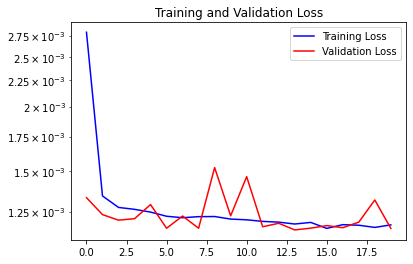

In [27]:
plot_train_history(history, 'Training and Validation Loss')

In [28]:
# Prediction on test datasets for MLP
mlp_pred = model.predict(X_test)

# Prediction on test datasets for Linear
lm_pred = lm.predict(X_test)

# Persistence Prediction
pers_pred = np.repeat(np.expand_dims(X_test[:, n_steps_in-1], axis = 1), n_steps_out, axis = 1)

544/544 [==============================] - 1s 2ms/step


### Visualize some of the predictions from the two baseline models and the feedforward NN model, along with the true labels

### Reverse the Normalization

In [29]:
def plot_results(x, true_pred, lm_pred, pers_pred, mlp_pred, ix):


  x = (train_max - train_min)*x + train_min
  true_pred = (train_max - train_min)*true_pred + train_min
  pers_pred = (train_max - train_min)*pers_pred + train_min
  lm_pred = (train_max - train_min)*lm_pred + train_min
  mlp_pred = (train_max - train_min)*mlp_pred + train_min

# Input Data
  plt.plot(np.arange(-n_steps_in+1, 1), x[ix], 'k--')

#Persistence Prediction
  plt.plot(np.arange(1, n_steps_out+1), pers_pred[ix], 'g')

# MLP prediction
  plt.plot(np.arange(1, n_steps_out+1), mlp_pred[ix], 'b')

#True Observed Future
  plt.plot(np.arange(1, n_steps_out+1), true_pred[ix], 'r')

#Legend
  plt.legend(["Input Tempt", "Persistence", "Linear", "MLP", "True Tempt"])
  plt.grid()
  plt.xlabel("Input [h]")
  plt.ylabel("Temperature [c]")

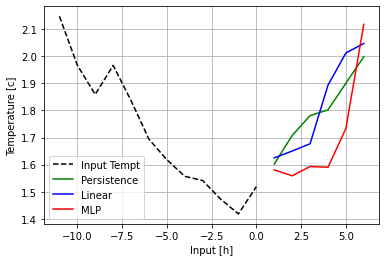

In [30]:
plot_results(X_test, y_test, pers_pred, lm_pred, mlp_pred, np.random.randint(0, len(y_test)))

### Verify the models on the test dataset, using the mean squared error as verification metric. In particular, plot the mean squared error of the models as a function of the prediction time step

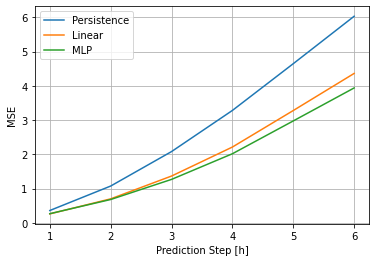

In [31]:
pers_mse = np.zeros(n_steps_out)
lm_mse = np.zeros(n_steps_out)
mlp_mse = np.zeros(n_steps_out)

for i in range(n_steps_out):
  pers_mse[i] = np.mean(np.square(y_test[:, i] - pers_pred[:, i]))
  lm_mse[i] = np.mean(np.square(y_test[:, i] - lm_pred[:, i]))
  mlp_mse[i] = np.mean(np.square(y_test[:, i] - mlp_pred[:, i]))

plt.plot(np.arange(1, n_steps_out+1), pers_mse*(train_max - train_min)**2)
plt.plot(np.arange(1, n_steps_out+1), lm_mse*(train_max - train_min)**2)
plt.plot(np.arange(1, n_steps_out+1), mlp_mse*(train_max - train_min)**2)

plt.legend(["Persistence", "Linear", "MLP"])
plt.xlabel("Prediction Step [h]")
plt.ylabel("MSE")
plt.grid()